0
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
1
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
2
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
3
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
4
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
5
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
6
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
7
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
8
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
9
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
10
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
11
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
12
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
13
dim phase screen: 100
padfact2 462
Phase screen shape: (1024, 1024)
14
dim phase scr

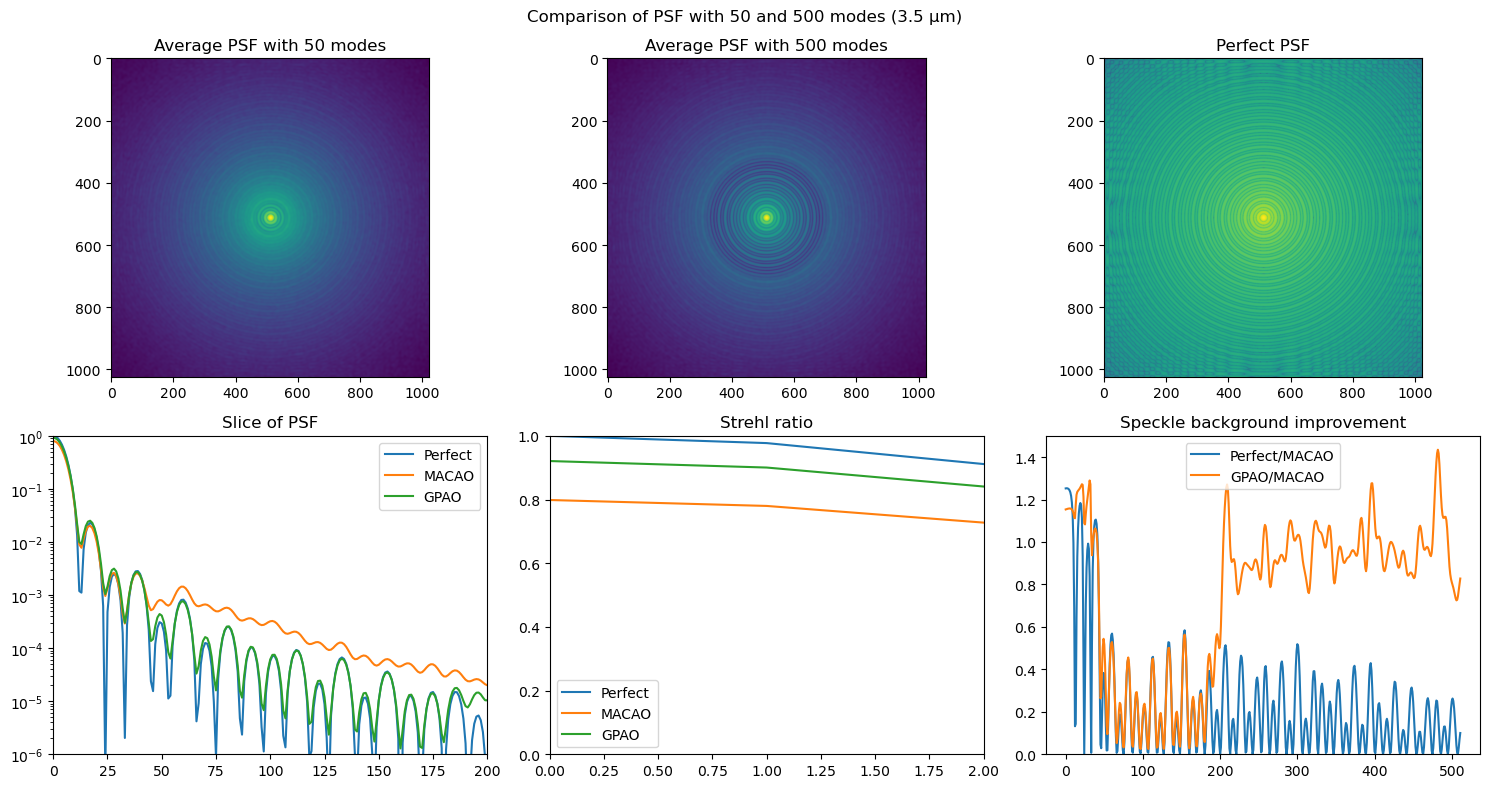

In [4]:
################################################
# 
# Jules Scigliuto, Florentin Millour
# with the help of Marcel Carbillet
# 
########################################################
# Support work for Houllé et al. 2025
# Plot of flux vs separation for exoplanets
# at the entrance of the MATISSE instrument (with AO)

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.special import jv
from astropy.io import fits


################################################
# Functions

def twoDtukey(NAXIS, alpha, tukDiam='same'):
    '''
    Create a 2D Tukey window

    Parameters:
    NAXIS (int): The size of the array
    alpha (float): The alpha parameter of the Tukey window

    Returns:
    ndarray: A 2D Tukey window
    '''
    if tukDiam == 'same':
        tukDiam = NAXIS
    axis = np.linspace(-NAXIS/2, NAXIS/2-1, NAXIS)
    x, y = np.meshgrid(axis, axis)
    r = np.sqrt(x**2 + y**2)
    
    tukey = np.zeros((NAXIS, NAXIS))
    tukey = np.where((r >= tukDiam/2 - alpha * NAXIS/2) & (r <= tukDiam/2), 0.5 * (1 + np.cos(np.pi * (r - tukDiam/2 - alpha * NAXIS/2) / (alpha * NAXIS/2))), tukey)
    tukey = np.where(r < tukDiam/2 - alpha * NAXIS/2, 1, tukey)
    
    return np.double(tukey)

################################################

def dist(NAXIS):
    '''
    Create a 2D array with the distance from the center of the array

    Parameters:
    NAXIS (int): The size of the array

    Returns:
    tuple: A tuple containing the 2D array with distances, and the x and y coordinates of the array
    '''
    axis = np.linspace(-NAXIS/2, NAXIS/2-1, NAXIS)
    x, y = np.meshgrid(axis, axis)
    r = np.sqrt(x**2 + y**2)
    xnorm = 2 * x / NAXIS
    ynorm = 2 * y / NAXIS
    return r, x, y, xnorm, ynorm

################################################

def generate_pupil_obstr(dim, D=8, D_obstr=1.2, plot=False):
    """
    Generates the pupil of the VLT.

    Parameters:
    - dim (int): Dimension of the wavefront screen.
    - D (float): Diameter of the pupil (in meters).
    - D_obstr (float): Diameter of the central obscuration (in meters).

    Returns:
    - pupil (ndarray): Pupil of the VLT.
    """
    x = np.linspace(-D / 2, D / 2, dim)
    xp, yp = np.meshgrid(x, x)
    rp = np.sqrt(xp**2 + yp**2)
    
    pupil = (rp < D / 2) * (rp > D_obstr / 2)
    #pupil = twoDtukey(dim, 2./dim) * (1-twoDtukey(dim*D_obstr/D, 2./(dim/2)))
    pupil  = twoDtukey(dim, 4./dim)
    pupil2 = twoDtukey(dim, 4./dim, tukDiam=dim*D_obstr/D)
    pupil *= (1 - pupil2)
    
    #plot=1
    
    if plot:
        #plt.imshow(pupil, origin='lower', extent=(-D / 2, D / 2, -D / 2, D / 2))
        plt.imshow(pupil, origin='lower')
        plt.title('Pupil of the VLT')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.show()
    
    return pupil

################################################

def generate_phase_screen_subharmonics(dim, length, L0, sha):
    '''
    directly inspired from the IDL routines of Marcel Carbillet
    '''
    # Additional parameters
    nsub = 3
    null = nsub // 2

    # Initialize the low-frequencies screen
    low_freq_screen = np.zeros((dim, dim), dtype=np.complex128)

    # Frequency (modulus), fx & fy (coordinates) "nsub*nsub" frequency arrays init.
    freq_x = np.float64(np.tile(np.arange(nsub) - 1, (nsub, 1)))
    #print(freq_x)
    freq_y = np.rot90(freq_x)
    #print(freq_y)
    freq_mod = np.sqrt(freq_x**2 + freq_y**2)
    #print(freq_mod)

    # xx and yy "dim*dim" screens
    xx = np.tile(np.arange(dim) / dim, (dim, 1))
    yy = xx.T

    # Cycle over order of sub-division (depth) of the null freq. px
    depth = 0
    while depth != sha:
        depth += 1

        phase = np.random.uniform(-0.5, 0.5, (nsub, nsub))
        freq_mod /= nsub
        freq_mod[null, null] = 1.0

        freq_x /= nsub
        freq_y /= nsub

        modul = (freq_mod**2 + (length / L0)**2)**(-11/12.)
        modul[null, null] = 0.0

        for i in range(nsub):
            for j in range(nsub):
                sh = np.exp(2j * np.pi * (xx * freq_x[i, j] + yy * freq_y[i, j] + phase[i, j]))
                sh0 = np.sum(sh) / dim**2

                low_freq_screen += (1.0 / nsub**depth) * modul[i, j] * (sh - sh0)

    low_freq_screen *= np.sqrt(0.0228) * dim**(5/6.)

    return low_freq_screen.real

################################################

def generate_phase_screen(dim, length, L0, r0, r0_lambda, plot=False, seed="seed", filter_nmodes=0, rejection=8.):
    """
    Generates a wavefront screen using the specified parameters.

    The model of the simulated phase screen has been taken from the equation (3) of Carbillet et al. 2010.

    Parameters:
    - dim (int): Dimension of the wavefront screen.
    - length (float): Length of the wavefront screen.
    - L0 (float): Outer scale of the turbulence.
    - r0 (float): Fried parameter of the turbulence.
    - wl (float): Wavelength of the light.
    - seed (str or int, optional): Seed for the random number generator. 
      If "seed" or "Seed" or "SEED", a fixed seed of 1 is used. 
      If "random" or "Random" or "RANDOM", a random seed is used. 
      If an integer is provided, that integer is used as the seed. 
      Defaults to "seed".

    Returns:
    - screen (ndarray): Generated wavefront screen.
    - x_ps (ndarray): x-coordinates of the points on the screen.
    - y_ps (ndarray): y-coordinates of the points on the screen.

    Directly inspired from the IDL routines of Marcel Carbillet
    [marcel.carbillet@unice.fr],
    lab. Lagrange (UCA, OCA, CNRS), Feb. 2013.
    """

    if seed in ["seed", "Seed", "SEED"]:
        np.random.seed(1)
    elif isinstance(seed, int):
        np.random.seed(seed)
    elif seed in ["random", "Random", "RANDOM"]: 
        np.random.seed()
    
    phase = np.random.uniform(low=-np.pi, high=np.pi, size=(dim, dim))
    rr, x_ps, y_ps, x_p, y_p = dist(dim)
    
    #print(x_ps, x_ps.shape)
    modul = (rr**2 + (length / L0)**2)**(-11./12.)
    
    # Set amplitude of mode 0 to 0
    #modul[np.where(rr==0)] = 0.0
    #compute subharmonics
    subh_term = generate_phase_screen_subharmonics(dim, length, L0, 9)
    
    if filter_nmodes > 0:
        nmradius = np.sqrt(np.pi * filter_nmodes)
        nmr_int = int(np.ceil(nmradius))
        # Modes antialiasing
        camembert_smooth = twoDtukey(nmr_int, 5./nmradius)
        if plot:
            plt.imshow(camembert_smooth)
            plt.show()
        
        if nmr_int % 2 == 0:
            pcs = np.pad(camembert_smooth, ((dim//2 - camembert_smooth.shape[0]//2, dim//2 - camembert_smooth.shape[0]//2),
                                            (dim//2 - camembert_smooth.shape[1]//2, dim//2 - camembert_smooth.shape[1]//2)), mode='constant')
        else:
            pcs = np.pad(camembert_smooth, ((dim//2 - camembert_smooth.shape[0]//2, dim//2 - camembert_smooth.shape[0]//2-1),
                                            (dim//2 - camembert_smooth.shape[1]//2, dim//2 - camembert_smooth.shape[1]//2-1)), mode='constant')
        #print('shape of pcs', np.shape(pcs))
        
        imod = np.where(rr > nmradius)
        modval = np.max(modul[imod])
        #print('modval',modval)
        #modul = np.where(rr > nmradius, modul, 0.1 * modval)
        modul = modul * (1-pcs) + pcs * modul / rejection
    
    #modul = (x_ps**2 + y_ps**2 + (length / L0)**2)**(-11./12.)
    
    if plot:
        plt.figure()
        plt.plot(np.sqrt(x_ps**2 + y_ps**2), modul)
        plt.xlabel('radius element number')
        plt.ylabel('energy')
        plt.title('amplitude of FFT of phase screen')
        plt.loglog()
    
        plt.figure()
        plt.imshow(modul)
        plt.imshow(np.fft.fftshift(np.log(modul)))
        plt.colorbar().set_label('energy')
        plt.title('amplitude of FFT of phase screen')
    
        plt.figure()
        plt.imshow(phase)
        plt.imshow(np.fft.fftshift(phase))
        plt.colorbar().set_label('energy')
        plt.title('phase of FFT of phase screen')
        plt.show()
    
    screen0 = np.fft.fftshift(modul) * np.exp(1j * phase)
    #print(screen0)
    screen  = np.fft.fft2(screen0).real
    screen2 = np.fft.fftshift(screen)
    fact    = np.sqrt(2)*np.sqrt(.0228)*(length/r0)**(5./6.)# * (2*np.pi) / wl 
    #print('fact',fact)
    screen3 = fact * screen2
    screen4 = screen3 + subh_term / rejection    
    screen5 = screen4 - np.mean(screen4)
    
    # Take wavelength of definition of r0
    #screen3 *= 2.2 / 3.5
    screen6 = screen5 * r0_lambda / (2*np.pi)
    
    scaling = length/dim
    #print('scaling',scaling)

    if plot:
        xm = np.linspace(0, dim, dim) * scaling #1pix = 9.7mm
        #plt.imshow(screen.real * 1e6, origin='lower', extent=(np.min(xm), np.max(xm), np.min(xm), np.max(xm))) #phase screen on a 10-meter square
        plt.imshow(screen6) #phase screen on a 10-meter square
        plt.colorbar().set_label('Astmospheric phase (radians)')
        plt.title('Real part of phase screen')
        plt.show()

    return screen6, scaling, x_ps

################################################

def generate_turbulent_psf(D, sz, phase_screen, lambda_obs, plot=False, n_pad=2, gen_perfect_psf=False):
    """
    Generates the electric field and point spread function (PSF) for a given phase screen.

    Parameters:
    - D (float): Diameter of the pupil (in meters).
    - Physical size of the phase screen (in meters).
    - phase_screen (ndarray): Phase screen representing the wavefront distortion.

    Returns:
    - E_img (ndarray): Electric field in the image plane.
    - psf (ndarray): Point spread function.
    - x_f (ndarray): x-coordinates of the points in the Fourier plane.
    """
    phase_screen = phase_screen * 2 * np.pi / lambda_obs
    
    dim = phase_screen.shape[0]
    print('dim phase screen:', dim)
    x = np.linspace(-sz / 2, sz / 2, dim)
    xmin = np.min(x)
    xmax = np.max(x)
    step = x[1] - x[0]
    
    pupil = generate_pupil_obstr(dim, D, 1.2, plot=plot)
    pupil /= pupil.sum()
    
    pscreen = np.copy(pupil) * np.exp(1j * phase_screen)
    wp = np.where(pscreen == 0)
    pscreen[wp] = 0
    
    paddim = 2**int(np.ceil(np.log2(dim * n_pad)))
    #print('paddim',paddim)
    padfact2 = int(paddim // 2 - dim/2) *2 +50
    # padfact2 = int(paddim // 2 - dim/2) 
    print('padfact2',padfact2)
    ppscreen = np.pad(pscreen, ((padfact2, padfact2), (padfact2, padfact2)), mode='constant')
    print('Phase screen shape:', ppscreen.shape)

    x_pad = np.arange(-paddim/2*step, paddim/2*step, step)
    min_xp = np.min(x_pad)
    max_xp = np.max(x_pad)
    
    E_img = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(ppscreen)))
    psf = np.abs(E_img)**2

    if gen_perfect_psf:
        # Generate a perfect PSF for comparison
        pup_pad = np.pad(pupil, ((padfact2, padfact2), (padfact2, padfact2)), mode='constant')
        E_perfect = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pup_pad)))
        psf_perfect = np.abs(E_perfect)**2 # perfect PSF
    
    
    #print(E_img.shape)

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))
        
        ax1.imshow(np.angle(pscreen), origin='lower', extent=(xmin, xmax, xmin, xmax))
        ax1.set_title('Turbulence on the Pupil')
        #ax1.set_xlim(-8, 8)
        #ax1.set_ylim(-8, 8)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')

        ax2.imshow(np.angle(ppscreen), origin='lower', extent=(min_xp, max_xp, min_xp, max_xp))
        ax2.set_title('Turbulence on the Pupil (zero padded)')
        #ax1.set_xlim(-8, 8)
        #ax1.set_ylim(-8, 8)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')

        ax3.imshow(np.log(psf))
        #ax3.imshow(psf)
        ax3.set_title('PSF')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Y')

        plt.tight_layout()
        plt.show()
    
    if gen_perfect_psf:
        return E_img, psf, x_pad, E_perfect, psf_perfect
    else:
        return E_img, psf, x_pad




################################################
################################################

dim  = 100 #pix -> 1024pix = 10m -> 1pix = 9.7mm
n_pad= 4
phsz = 8.0 #m physical size of the phase screen (in meters)
L0   = 30.0 # outer scale m
D    = 8.0 # telescope diameter m
D_obs = 1.2 # central obscuration m
r0   = 0.1 # Fried diameter m
r0_lamb = 0.5e-6 #m
rejection = 8.
#lam  = 0.655e-6 #m 
#lam  = 1.2e-6 #m 
#lam  = 2.2e-6 #m 
lam  = 3.5e-6 #m 
# sep  = 405.018 #534 #mas
# sep_rad = (sep * 1e-3 / 3600) * (np.pi / 180) #Séparation étoile-planète en rad
# sep_lam = sep_rad / (lam / D) #Séparation étoile-planète en lam/D
# holediam = 1.5 #lam/D at 3.5µm
# pl_flx = 0.3e-3 #Jy
# st_flx = 2 #Jy
# rt_flx = pl_flx / st_flx #unitless
nrepeat = int(1183/10)

plot = False

# Generate phase screen
#screen, scaling, x_ps = generate_phase_screen(dim, phsz, L0, r0, plot, seed="seed", filter_nmodes=800)

#screenM = screen / 2 / np.pi * lam

PSF50 = []
for i in range(nrepeat):
    print(i)
    screen, scaling, x_ps = generate_phase_screen(dim, phsz, L0, r0, r0_lamb, plot=plot, seed="random", filter_nmodes=50, rejection=rejection)
    if i == 0:
        E_img_perfect, psf, ps_dim, E_perfect, psf_perfect = generate_turbulent_psf(D, phsz, screen, lam, plot=plot, n_pad=n_pad, gen_perfect_psf=True)
    else:
        E_img_50, psf, ps_dim = generate_turbulent_psf(D, phsz, screen, lam, plot=plot, n_pad=n_pad)
    PSF50.append(psf)
average_PSF50 = np.mean(PSF50, axis=0)
average_PSF_PERFECT = psf_perfect

PSF500 = []
for i in range(nrepeat):
    print(i)
    screen, scaling, x_ps = generate_phase_screen(dim, phsz, L0, r0, r0_lamb, plot=plot, seed="random", filter_nmodes=500, rejection=rejection)
    E_img_500, psf, ps_dim = generate_turbulent_psf(D, phsz, screen, lam, plot=plot, n_pad=n_pad)
    PSF500.append(psf)
average_PSF500 = np.mean(PSF500, axis=0)

fits.writeto('real_E_img_500.fits', E_img_500.real, overwrite=True)
fits.writeto('imag_E_img_500.fits', E_img_500.imag, overwrite=True)
fits.writeto('average_PSF500.fits', average_PSF500, overwrite=True)


dim = average_PSF500.shape[0]

fig0, ax0 = plt.subplots(2, 3, figsize=(15, 8))

plt.suptitle(f'Comparison of PSF with 50 and 500 modes ({lam*1e6} µm)')

ax0[0,0].set_title('Average PSF with 50 modes')
ax0[0,0].imshow(np.log(average_PSF50))

ax0[0,1].set_title('Average PSF with 500 modes')
ax0[0,1].imshow(np.log(average_PSF500))

ax0[0,2].set_title('Perfect PSF')
ax0[0,2].imshow(np.log(average_PSF_PERFECT))

slice50   = average_PSF50[dim//2,dim//2:]
#slice50  /= np.max(slice50)
slice500  = average_PSF500[dim//2,dim//2:]
slicePERFECT  = average_PSF_PERFECT[dim//2,dim//2:]
#slice500 /= np.max(slice500)

ax0[1,0].set_title('Slice of PSF')
ax0[1,0].plot(slicePERFECT, label='Perfect')
ax0[1,0].plot(slice50, label='MACAO')
ax0[1,0].plot(slice500, label='GPAO')
ax0[1,0].set_yscale('log')
mx = np.max(slicePERFECT)
ax0[1,0].set_ylim(mx/1e6, mx)
ax0[1,0].set_xlim(0, 200)
ax0[1,0].legend()

maxp = np.max(slicePERFECT)
ax0[1,1].set_title('Strehl ratio')
ax0[1,1].plot(slicePERFECT / maxp, label='Perfect')
ax0[1,1].plot(slice50 / maxp, label='MACAO')
ax0[1,1].plot(slice500 / maxp, label='GPAO')
ax0[1,1].set_xlim(0, 2)
ax0[1,1].set_ylim(0, 1)
ax0[1,1].legend()

ax0[1,2].set_title('Speckle background improvement')
ax0[1,2].plot(slicePERFECT/slice50, label='Perfect/MACAO')
ax0[1,2].plot(slice500/slice50, label='GPAO/MACAO')
#ax0[1,2].set_yscale('log')
ax0[1,2].set_ylim(0, 1.5)
ax0[1,2].legend()

plt.tight_layout()

print('gain in speckle background',np.mean((slice500/slice50)[30:90]))

plt.show()

PSF shape: (1024, 1024)


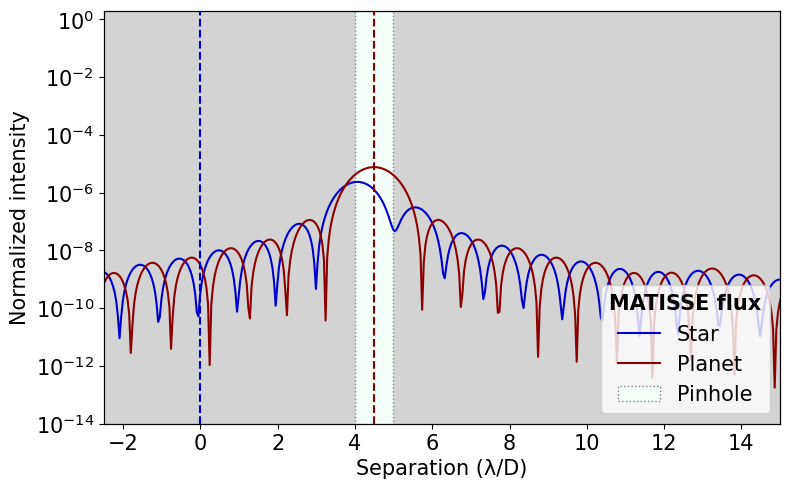

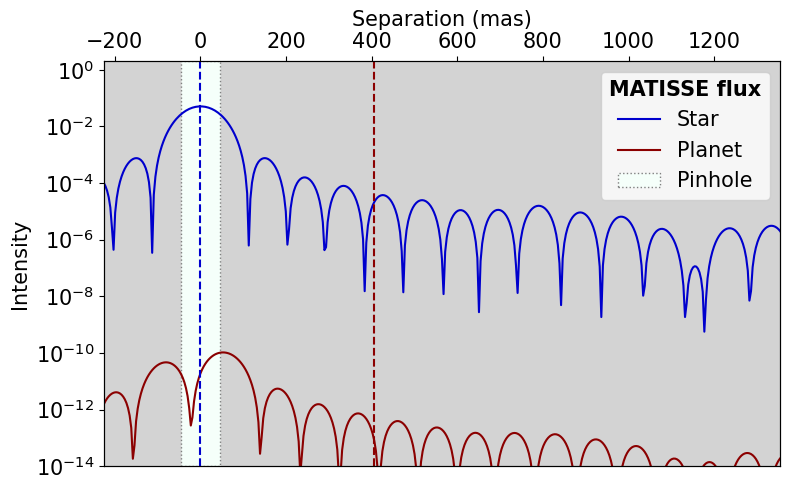

Séparation en lambda/D: 4.488188971328504, et l'index sur la plage de fréquence (x_f) 620 et sa valeur 4.5
Séparation en lambda/D: 4.488188971328504, et l'index sur la plage de fréquence (xf_offset) 512 et sa valeur 4.488188971328504
R at planet position: 5.509428885884911e-09
C at the planet position: 2.4044405305932505e-05
Intensité moyenne dans le pinhole pour la planète: 7.653206708258357e-06
Intensité moyenne dans le pinhole pour l'étoile: 1.448327019318308e-06
Ratio: 5.284170360821228
Intensité à la position de la planète pour la planète: 7.688149976609455e-06
Intensité à la position de la planète pour l'étoile: 1.2852235906077777e-06
Ratio: 5.981955227707698


In [222]:
# ###############################################
# 
# Jules Scigliuto
# 
# 
########################################################
# Figure 1 of Houllé et al. 2025
# Plot of flux vs separation for exoplanets
# through the MATISSE instrument (no AO)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tkinter as tk

# ###############################################
# #
# Notations : #
# #
# sf = Spatial Filtering #
# c = Centered # 
# off/on = off/on-axis #
# plan = Planète #
# flx = Flux #
# psd = power spectral density #
# ##############################################

##### Paramètres 
lam = 3.5e-6 #Longueur d'onde
n_pix = 1024 #Nombre de pixel
D = 8 #Diamètre du télescope
D1 = 50
sep = 405.018 #Séparation étoile-planète en mas
sep_rad = (sep*1e-3/3600) * (np.pi/180) #Séparation étoile-planète en rad
sep_lam = sep_rad/(lam/D) #Séparation étoile-planète en lam/D
plan_flx = 0.3e-3 #Flux de la planète en Jy
star_flx = 2 #Flux de l'étoile en Jy
holediam = 1 #En lam/D à 3.5µm
a = 15 #Borne pour le plot final en lam/D

plotquisertarien = False

r0_500nm = 0.1 #Paramètre de Fried à 500 nm
r0 = r0_500nm * (lam/500e-9)**(6/5) #Rayon de Fried en mètre à lam souhaitée
k0 = 2*np.pi/D1 #Nombre d'onde (grande échelle)



##### Masque de phase - Kolmogorov
# fx, fy = np.meshgrid((np.arange(n_pix) - n_pix//2)*2*np.pi/D, (np.arange(n_pix) - n_pix//2)*2*np.pi/D)
# freq = np.sqrt(fx**2 + fy**2)
# k_psd = 0.023*r0**(-5/3)*freq**(-11/3)
# k_psd[n_pix//2,n_pix//2] = 0.023*r0**(-5/3)*k0**(-11/3)

# random_table = np.random.random((n_pix,n_pix))
# random_table_spectrum = np.fft.fft2(random_table)
# k_phase_screen_spectrum = random_table_spectrum * np.sqrt(k_psd)

# k_phase_screen = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(k_phase_screen_spectrum))))

# if plotquisertarien:
#     plt.figure(figsize=(14,4))
#     plt.subplot(131)
#     plt.imshow(np.abs(random_table_spectrum)**2,origin='lower',norm=LogNorm())
#     plt.title('Random spectrum (white noise)')
#     plt.subplot(132)
#     plt.imshow(np.abs(k_phase_screen_spectrum)**2,origin='lower',norm=LogNorm())
#     plt.title('PSD of the turbulence')
#     plt.subplot(133)
#     plt.imshow(k_phase_screen,origin='lower')
#     plt.title('Phase screen')
#     plt.show()


##### Modélisation du plan pupille + masque de phase
npad = 12
x = np.linspace(-npad*D, npad*D, n_pix)
xx,yy = np.meshgrid(x,x)
r = np.sqrt(xx**2+yy**2)
pupil = (r<D/2)
pupil = 1.0*pupil
pupil /= pupil.sum()

if plotquisertarien:
    plt.figure()
    plt.imshow(pupil, origin='lower', extent=(np.min(x), np.max(x), np.min(x), np.max(x)))
    plt.xlim(-5,5)
    plt.ylim(-5,5)

    # plt.figure()
    # plt.imshow(k_phase_screen*pupil)
    

##### Calcul de la PSF d'un point source à travers un télescope de 8
# E_img = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(pupil)))
# psf = np.abs(E_img*E_img)
E_img = E_img_500 
psf = average_PSF500

print('PSF shape:', psf.shape)


x_f = np.fft.fftshift(np.fft.fftfreq(n_pix,(2*npad*D)/n_pix))*D

if plotquisertarien:
    ##### Cut de PSF de d'un point source à travers un télescope de 8m
    plt.figure()
    plt.plot(x_f, psf[n_pix//2]/np.max(psf))
    plt.xlim(0,20)
    plt.xlabel('λ/D')
    plt.yscale('log')
    plt.ylabel('$I_{normalized}$')
    plt.ylim(10e-7)

    ##### PSF de d'un point source à travers un télescope de 8m
    plt.figure()
    plt.imshow(np.log(psf), origin='lower', extent=(np.min(x_f), np.max(x_f), np.min(x_f), np.max(x_f)))
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    #print(x_f)

##### Modélisation du pinhole
x2, y2 = np.meshgrid(x_f, x_f)
r2 = np.sqrt(x2**2+y2**2)
pinhole = (r2<((holediam/3.5e-6)*(lam/2)))

##### Shifted pinhole
x3 = x2-sep_lam
y3 = y2
r3 = np.sqrt(x3**2+y3**2)
pinhole_off = (r3<((holediam/3.5e-6)*(lam/2)))

###### Planète
coordxy = np.where(r3==np.min(r3)) #Coordonnées de la planète dans r3
Eplan_img = np.roll(E_img, coordxy[1][0]-n_pix//2, axis=1) #Champ électrique de la planète à sa position

##### Filtrage spatial par le pinhole pour étoile on-axis
sf = pinhole * E_img

##### Filtrage spatial par le pinhole pour étoile off-axis
sf2 = pinhole_off * E_img
sf2_c = np.roll(sf2, n_pix//2-coordxy[1][0], axis=1)

##### Filtrage spatial par le pinhole pour planète off-axis
sf3 = pinhole * Eplan_img

##### Filtrage spatial par le pinhole pour planète on-axis
sf4 = pinhole_off * Eplan_img
sf4_c = np.roll(sf4, n_pix//2-coordxy[1][0], axis=1)

if plotquisertarien:
    plt.figure()
    plt.imshow(np.abs(Eplan_img), origin='lower', extent=(np.min(x_f), np.max(x_f), np.min(x_f), np.max(x_f)))
    plt.title('Eplan')
    plt.xlim(-15,15)
    plt.ylim(-5,5)

    plt.figure()
    plt.imshow(np.abs(sf4), origin='lower', extent=(np.min(x_f), np.max(x_f), np.min(x_f), np.max(x_f)))
    plt.title('sf')
    plt.xlim(-10,10)
    plt.ylim(-5,5)

##### Intensité du signal du point source à la sortie du pinhole de MATISSE 
# I_pin = np.abs(pinhole*pinhole)

# plt.figure();
# plt.plot(x_f, I_pin[n_pix//2]/np.max(I_pin), 'r');
# plt.yscale('log');
# plt.xlabel('λ/D');
# plt.xlim(0,2)

##### Modélisation de l'OTF de la pupille
E_pup_on = np.fft.fftshift(np.fft.fft2(sf))/n_pix
otf_pup = np.abs(E_pup_on*E_pup_on)

E_pup_off = np.fft.fftshift(np.fft.fft2(sf2_c))/n_pix 
# otf_pup_filt = np.abs(E_pup_off*E_pup_off)

Eplan_pup_off = np.fft.fftshift(np.fft.fft2(sf3))/n_pix 
# otf_pup_plan = np.abs(Eplan_pup_off*Eplan_pup_off)

Eplan_pup_on = np.fft.fftshift(np.fft.fft2(sf4_c))/n_pix 
# otf_pup_plan = np.abs(Eplan_pup_on*Eplan_pup_on)

x_otf = np.linspace(0,n_pix,n_pix )
otf_abs = np.abs(Eplan_pup_on)

if plotquisertarien:
    plt.figure()
    plt.plot(x_f, otf_abs[n_pix//2])
    plt.title('OTF')

    plt.figure()
    plt.imshow(otf_abs)

##### 'Pupil Stop' 
pup_stop = r<D/2

E_pup_stop = E_pup_on*pup_stop

E_pup_off_stop = E_pup_off*pup_stop

Eplan_pup_off_stop = Eplan_pup_off*pup_stop

Eplan_pup_on_stop = Eplan_pup_on*pup_stop

if plotquisertarien:
    plt.figure()
    plt.imshow(np.abs(Eplan_pup_off_stop))

##### PSF du point source après le 'Pupil Stop'
E_onstar = np.fft.fft2(E_pup_stop)/n_pix
psf_on = np.abs(E_onstar*E_onstar)

E_offstar = np.fft.fft2(E_pup_off_stop)/n_pix
psf_off= np.abs(E_offstar*E_offstar)

Eplan_off = np.fft.fft2(Eplan_pup_off_stop)/n_pix
psf_offplan = np.abs(Eplan_off*Eplan_off)

Eplan_on = np.fft.fft2(Eplan_pup_on_stop)/n_pix
psf_onplan = np.abs(Eplan_on*Eplan_on)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

xf_offset = x_f + sep_lam

##### Plots finals 
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(xf_offset, psf_off[n_pix//2], 'mediumblue', label='Star')
ax1.plot(xf_offset, psf_onplan[n_pix//2]*(plan_flx/star_flx), 'darkred', linestyle = '-', label='Planet')

ax1.axvline(x=0, color='mediumblue', linestyle='--')
ax1.axvline(x=sep_lam, color='darkred', linestyle='--')

#ax1.axvline(x=sep_lam+holediam/2, color='grey', linestyle=':')
#ax1.axvline(x=sep_lam-holediam/2, color='grey', linestyle=':')
ax1.axvspan(sep_lam-holediam/2, sep_lam+holediam/2, facecolor='mintcream', edgecolor='grey', alpha=1, label='Pinhole', linestyle=':')

ax1.set_xlim(-2.5,a)
ax1.set_xlabel('Separation (λ/D)', fontsize=15)
ax1.set_yscale('log')
ax1.set_ylabel('Normalized intensity', fontsize=15)
ax1.set_ylim(1e-14,2)
#ax1.get_yaxis().set_visible(False)
ax1.set_facecolor('lightgrey')

ax1.legend(title="MATISSE flux", loc='lower right', title_fontproperties={'weight':'bold'})

#plt.rcParams["figure.figsize"] = (8, 6)

ax2 = ax1.twiny()

ax2.get_xaxis().set_visible(False)
ax2.set_xlim(-2.5*(sep/sep_lam), a*(sep/sep_lam))
#ax2.set_xlabel('Separation (mas)', fontsize=15)

plt.tight_layout()

plt.savefig('figbetapic1.pdf', format='pdf')
plt.savefig('figbetapic1.png', format='png')
#plt.show()

##############################################################

fig, ax3 = plt.subplots(figsize=(8,5))

ax3.plot(x_f, psf_on[n_pix//2], 'mediumblue', label='Star')
ax3.plot(x_f, psf_offplan[n_pix//2]*(plan_flx/star_flx), 'darkred', linestyle='-', label='Planet')

ax3.axvline(x=0, color='mediumblue', linestyle='--')
ax3.axvline(x=sep_lam, color='darkred', linestyle='--')

ax3.axvspan(-holediam/2, holediam/2, facecolor='mintcream', alpha=1, edgecolor='grey', label='Pinhole', linestyle=':')

ax3.set_xlim(-2.5,a)
#ax3.set_xlabel('Separation (λ/D)', fontsize=15)
ax3.set_yscale('log')
ax3.set_ylabel('Intensity', fontsize=15)
ax3.set_ylim(1e-14,2)
ax3.legend(title="MATISSE flux",loc='upper right', title_fontproperties={'weight':'bold'})

ax3.set_facecolor('lightgrey')
ax3.get_xaxis().set_visible(False)

ax4 = ax3.twiny()

ax4.set_xlim(-2.5*(sep/sep_lam), a*(sep/sep_lam))
ax4.set_xlabel('Separation (mas)', fontsize=15)
plt.tight_layout()
plt.savefig('figbetapic2.pdf', format='pdf')
plt.savefig('figbetapic2.png', format='png')
plt.show()

################### Prints

sep_lam_index = np.argmin(np.abs(x_f - sep_lam))
sep_lam_offset_index = np.argmin(np.abs(xf_offset - sep_lam))

print("Séparation en lambda/D: {}, et l'index sur la plage de fréquence (x_f) {} et sa valeur {}".format(sep_lam, sep_lam_index, x_f[sep_lam_index]))
print("Séparation en lambda/D: {}, et l'index sur la plage de fréquence (xf_offset) {} et sa valeur {}".format(sep_lam, sep_lam_offset_index, xf_offset[sep_lam_offset_index]))
R = psf_off[n_pix//2, sep_lam_index]  # faire une moyenne / ou OA
print('R at planet position:', R)
C = psf_offplan[n_pix//2, sep_lam_index] / psf_on[n_pix//2, sep_lam_index]
print('C at the planet position:', C)


# print(psf_onplan[n_pix//2, int(sep_lam_offset_index-holediam/2)]*(plan_flx/star_flx),
#       psf_onplan[n_pix//2, int(sep_lam_offset_index+holediam/2)]*(plan_flx/star_flx))
# print(psf_onplan[n_pix//2, int(sep_lam_offset_index-holediam/2):int(sep_lam_offset_index+holediam/2)]*(plan_flx/star_flx))

bound_sup_ph = int(sep_lam_offset_index+holediam/2)
bound_inf_ph = int(sep_lam_offset_index-holediam/2)

# bound_inf = bound_inf_ph
# bound_sup = bound_inf_ph
# mean_star_intensity_list = []
# mean_planet_intensity_list = []

# while bound_inf != bound_sup:
#     xi = psf_off[n_pix//2, bound_sup]
#     yi = psf_offplan[n_pix//2, bound_sup]*(plan_flx/star_flx)
#     print(xi, yi)
#     mean_star_intensity_list.append(xi)
#     mean_planet_intensity_list.append(yi)
#     bound_inf += 1

# intensity_star_pinhole = np.mean(mean_star_intensity_list)
# intensity_planet_pinhole = np.mean(mean_planet_intensity_list)

intensity_star_pinhole = np.mean(psf_off[n_pix//2, bound_inf_ph:bound_sup_ph])
intensity_planet_pinhole = np.mean(psf_onplan[n_pix//2, bound_inf_ph:bound_sup_ph]*(plan_flx/star_flx))

print("Intensité moyenne dans le pinhole pour la planète:", intensity_planet_pinhole)
print("Intensité moyenne dans le pinhole pour l'étoile:", intensity_star_pinhole)
print('Ratio:', intensity_planet_pinhole/intensity_star_pinhole)

intensity_planet = psf_onplan[n_pix//2, sep_lam_offset_index]*(plan_flx/star_flx)
intensity_star = psf_off[n_pix//2, sep_lam_offset_index]

print("Intensité à la position de la planète pour la planète:", intensity_planet)
print("Intensité à la position de la planète pour l'étoile:", intensity_star)
print('Ratio:', intensity_planet/intensity_star)

In [ ]:
dim  = 100 #pix -> 1024pix = 10m -> 1pix = 9.7mm
n_pad= 4
phsz = 8.0 #m physical size of the phase screen (in meters)
L0   = 30.0 # outer scale m
D    = 8.0 # telescope diameter m
D_obs = 1.2 # central obscuration m
r0   = 0.1 # Fried diameter m
r0_lamb = 0.5e-6 #m
rejection = 8.
lam  = 3.5e-6 #m 
nrepeat = 1183

lam = 3.5e-6 #Longueur d'onde
n_pix = 1024 #Nombre de pixel
D = 8 #Diamètre du télescope
D1 = 50
sep = 405.018 #Séparation étoile-planète en mas
sep_rad = (sep*1e-3/3600) * (np.pi/180) #Séparation étoile-planète en rad
sep_lam = sep_rad/(lam/D) #Séparation étoile-planète en lam/D
plan_flx = 0.3e-3 #Flux de la planète en Jy
star_flx = 2 #Flux de l'étoile en Jy
holediam = 1.5 #En lam/D à 3.5µm
a = 10 #Borne pour le plot final en lam/D   